# Real Time Style Transfer with TensorFlow and Keras
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>

In this notebook, we'll implement a network that performs __neural style transfer__ based on paper by [Justin Johnson, et al](https://cs.stanford.edu/people/jcjohns/eccv16/).
>Using this method is giving similar qualitative results but is three orders of magnitude faster than optimization technique outlined in [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

## Overview
Neural style transfer is an optimization technique used to take three images, a __content__ image, a __style reference__ image (such as an artwork by a famous painter), and the input image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

In this paper, style transfer is done by training a deep convolutional neural network using a pretrained deep convolutional neural network. In this case, we're using [VGG16](https://arxiv.org/abs/1409.1556) pretrained on imagenet dataset.

# TODO: masukin gambar arsitektur networknya

## TODOS:
1. Create keras.Layers class instead of functions
2. Search for style images

### List of style images
1. starry night
2. hockney
3. monet
4. rain princess
5. the scream
6. udnie


In [61]:
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Activation, add, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from PIL import Image

import matplotlib.pyplot as plt
import os
import numpy as np

tf.enable_eager_execution()

### Load in the Content and Style images
Here, we create function to load image and do VGG16 standard preprocessing using `tf.keras.applications.vgg16.preprocess_input`.

In [129]:
def load_image(image_path, target_size=None):
    """ Load image from path and do VGG16 standard preprocessing with tf mode.
        Returns a tensor representation of the image.
    """
    if target_size is  not None:
        image = load_img(image_path)
    else:
        image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image, mode='tf')
    image = tf.convert_to_tensor(image)
    return image

In [131]:
def imshow(image, title=None):
    """ Showing image tensor
    """
    image = image.numpy()
    image = (image + 1.) * 127.5
    # Remove the batch dimension
    image = np.squeeze(image, axis=0)
    if title is not None:
        plt.title(title)
    plt.imshow(image/255.)
    
#     image = image.squeeze()
#     image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
#     image = image.clip(0, 1)
#     plt.imshow(image)

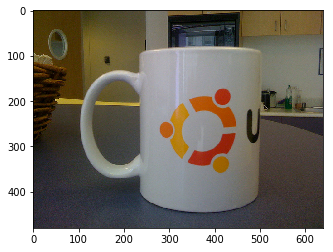

In [138]:
content_image = load_image("images/content/mug.jpg")
imshow(content_image)
content_shape = tf.shape(content_image)

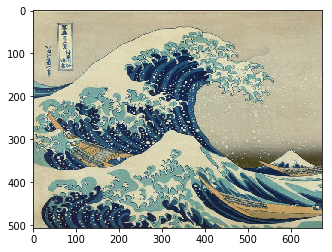

In [136]:
style_image = load_image("images/styles/wave_crop.jpg", target_size=)
imshow(style_image)

In [104]:
CONTENT_WEIGHT = 7.5e0
STYLE_WEIGHT = 1e2

Importing data

In [ ]:
name_of_zip = 'train2014.zip'
name_of_folder = 'train2014'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_folder):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  mscoco_path = os.path.dirname(image_zip)+'/train2014/'
else:
  mscoco_path = os.path.abspath('.')+'/train2014/'

In [ ]:
mscoco_path

In [ ]:
def reflection_padding():
    """Reflection padding layer for output size to match the input size"""
    def f(inputs):
        return tf.pad(inputs, [[0, 0], [40, 40], [40, 40], [0, 0]], "REFLECT")
    return f

def conv_layer(n_channels, kernel_size, strides, padding="same", relu=True):
    """Convolutional layer wrapper"""
    def f(inputs):
        conv = Conv2D(filters=n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        bn = BatchNormalization()(conv)
        if relu:
            return Activation("relu")(bn)
        else:
            return bn
        
    return f

def conv_transpose_layer(n_channels, kernel_size, strides, padding="same", relu=True):
    """Convolutional transpose layer to upsample the image"""
    def f(inputs):
        conv = Conv2DTranspose(n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
        bn = BatchNormalization()(conv)
        if relu:
            return Activation("relu")(bn)
        else:
            return bn
        
    return f

def residual_block(n_channels, kernel_size=3, strides=1, padding='valid'):
    """Residual Block. Center cropped the input to match output size"""
    def f(inputs):
        inputs_shape = inputs.get_shape().as_list()
        residual = tf.image.resize_image_with_crop_or_pad(inputs, inputs_shape[1] - 4, inputs_shape[2] - 4)
        conv_1 = Conv2D(filters=n_channels, kernel_size=kernel_size, 
                      strides=strides, padding=padding)(inputs)
        bn_1 = BatchNormalization()(conv_1)
        relu_1 = Activation("relu")(bn_1)
        conv_2 = Conv2D(filters=n_channels, kernel_size=kernel_size, 
                      strides=strides, padding=padding)(relu_1)
        bn_2 = BatchNormalization()(conv_2)
        return add([bn_2, residual])

    return f

In [ ]:
class StyleTransferModel(tf.keras.Model):
    """Style Transfer Model class"""
    def __init__(self):
        super(StyleTransferModel, self).__init__(name='style_transfer_model')
        
        # Layers
        self.pad = reflection_padding()
        self.conv_1 = conv_layer(32, 9, 1)
        self.conv_2 = conv_layer(64, 3, 2)
        self.conv_3 = conv_layer(128, 3, 2)
        self.res_1 = residual_block(128, 3, 1)
        self.res_2 = residual_block(128, 3, 1)
        self.res_3 = residual_block(128, 3, 1)
        self.res_4 = residual_block(128, 3, 1)
        self.res_5 = residual_block(128, 3, 1)
        self.conv_4 = conv_transpose_layer(64, 3, 2)
        self.conv_5 = conv_transpose_layer(32, 3, 2)
        self.conv_6 = conv_layer(3, 9, 1, relu=False)


        
    def call(self, inputs):
        # (width x height x channels)
        # 256 x 256 x 3

        # 336 x 336 x 3
        padded = self.pad(inputs)
        # 336 x 336 x 32
        conv_1_out = self.conv_1(padded)
        # 168 x 64 x 64
        conv_2_out = self.conv_2(conv_1_out)
        # 84 x 84 x 128
        conv_3_out = self.conv_3(conv_2_out)
        # 80 x 80 x 128
        res_1_out = self.res_1(conv_3_out)
        # 76 x 76 x 128
        res_2_out = self.res_2(res_1_out)
        # 72 x 72 x 128
        res_3_out = self.res_3(res_2_out)
        # 68 x 68 x 128
        res_4_out = self.res_4(res_3_out)
        # 64 x 64 x 128
        res_5_out = self.res_5(res_4_out)
        # 128 x 128 x 64
        conv_4_out = self.conv_4(res_5_out)
        # 256 x 256 x 32
        conv_5_out = self.conv_5(conv_4_out)
        # 256 x 256 x 3
        conv_6_out = self.conv_6(conv_5_out)
        
        tanh_out = (conv_6_out + 1) * 255. / 2
        return tanh_out

In [ ]:
net = StyleTransferModel()

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
content_image = load_img("images/content/mug.jpg")
content_image = img_to_array(content_image)
plt.imshow(content_image/255.)
plt.show()
content_image = content_image.reshape((1, content_image.shape[0], content_image.shape[1], content_image.shape[2]))
content_image = preprocess_input(content_image)
content_image = tf.convert_to_tensor(content_image)
tf.shape(content_image)

In [ ]:
style_image = load_img("images/styles/wave_crop.jpg", target_size=(480, 640))
style_image = img_to_array(style_image)
plt.imshow(style_image/255.)
plt.show()
style_image = style_image.reshape((1, style_image.shape[0], style_image.shape[1], style_image.shape[2]))
style_image = preprocess_input(style_image)
style_image = tf.convert_to_tensor(style_image)
tf.shape(style_image)

In [ ]:
y_hat = net(content_image)

In [ ]:
y_hat.dtype

In [ ]:
def get_style_features(model, image):
    """ Run an image forward through a model and get the features for 
        a set of style layers.
        Returns a dictionary of the layer name and the activations.
    """
    style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for layer in model.layers:
        x = layer(x)
        if layer.name in style_layers:
            features[layer.name] = x
            if layer.name == 'block4_conv3':
                break
            
    return features

def get_content_feature(model, image):
    """ Run an image forward through a model and get the features for 
        a set of conent layers.
        Returns the activation of the content layer
    """
    style_layers = ['block3_conv3']
    
    x = image
    # model._modules is a dictionary holding each module in the model
    for layer in model.layers:
        x = layer(x)
        if layer.name in style_layers:
            features = x
            break
            
    return features

In [ ]:
def gram_matrix(x):
    """ Compute gram matrix of a 3 dimensional convolution
    """
    b, h, w, c = tf.shape(x)
    x = tf.reshape(x, [b, c, -1])
    size = tf.to_float(c * h * w)
    return  tf.matmul(x, tf.transpose(x, perm=[0, 2, 1])) / size

In [ ]:
model = VGG16()

In [ ]:
def loss(y, content_image, style_image, content_weight, style_weight):
    """ Compute loss of output with respect to content and style image
    """
    # Pretrained VGG16 on imagenet
    model = VGG16()
    
    # Style features of output
    output_style_features = get_style_features(model, y)
    # Content features of output
    output_content_feature = get_content_feature(model, y)
    
    # Style features of style image
    style_features = get_style_features(model, style_image)
    # Content features of content image
    content_feature = get_content_feature(model, content_image)
    
    # Compute content loss
    # (output - content )/(Cj * Hj * Wj)
    content_loss = content_weight * tf.reduce_mean(tf.math.square(output_content_feature - content_feature))
    
    # Compute style loss
    # Gram matrix of output features
    output_grams = [gram_matrix(x) for _, x in output_style_features.items()]
                                                  
    # Gram matrix of style features
    style_grams = [gram_matrix(x) for _, x in style_features.items()]
    
    style_losses = [tf.square(tf.norm(output_gram - style_gram)) for output_gram, style_gram in zip(output_grams, style_grams)]
    style_loss = style_weight * tf.reduce_sum(tf.convert_to_tensor(style_losses)) / 4.
                                                  
    # TODO: Add total variation regularization
    
    total_loss = content_loss + style_loss
    return total_loss, content_loss, style_loss

In [ ]:
<tf.Tensor: id=18761, shape=(), dtype=float32, numpy=4519431000000.0>

In [ ]:
<tf.Tensor: id=12538, shape=(), dtype=float32, numpy=2355534000000.0>

In [ ]:
loss(y_hat, content_image, style_image, 1, 0.001)